## Conceptual description

Basis idee is een grid waarbij elke grid cell een agent is. Een agent heeft interactie met een random (=proportional to similarity) gekozen neighbor en neem dan een cultural trait over van zijn neighbor. Het originele model is van Axelrod (zie bijgevoegd paper). Er is ondertussen een hele literatuur (zie het Flache paper voor een recente review).  

- Space: SingleGrid; an 'excel-like' space with each agent occopying a single grid cell
- 1 agent type with attributes: 
    - **pos**: position (x, y)
    - Cultural traits, each with 2 possible values, e.g.: 
        - **music** = {Rock, Jazz}
        - **sports** = {Soccer, Cycling}
        - **favorite color** = {Red, Blue}
        - **drink** = {Tea, Coffee}
    - 
- Schedule: RandomActivation

Agent step:
- For each neighbor, calculate the similarity 
- Proportional to this similarity, pick a 'random' neighbor to interact with (+ noise?)
- Randomly pick one differing trait and change it



Plot: 
- 2D grid, coloured based on traits (?) 
- Number of distinct regions


In [18]:
import collections
import random

import numpy as np

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector


class CulturalDiff(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of grid
    seed : int
            random seed
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, seed=None):
        super().__init__(seed=seed)
        self.height = height
        self.width = width

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'diversity':calculate_nr_of_cultures})



        # Fill grid with agents with random traits
        
        # Note that this implementation does not guarantee some set distribution of traits. 
        # Therefore, examining the effect of minorities etc is not facilitated.
        for cell in self.grid.coord_iter():
            agent_music = self.random.choice(['Rock', 'Jazz'])
            agent_sport = self.random.choice(['Soccer', 'Cycling'])
            agent_color = self.random.choice(['Red', 'Blue'])
            agent_drink = self.random.choice(['Tea', 'Coffee'])
            
            agent = CulturalDiffAgent(cell, self, agent_music, agent_sport,
                                      agent_color, agent_drink)
            self.grid.position_agent(agent, cell)
            self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.datacollector.collect(self)
        self.schedule.step()


class CulturalDiffAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    agent_music : {'Rock', 'Jazz'}
    agent_sport : {'Soccer', 'Cycling'}
    agent_color : {'Red', 'Blue'}
    agent_drink : {'Tea', 'Coffee'}
    
    """

    def __init__(self, pos, model, agent_music, agent_sport, agent_color, agent_drink):
        super().__init__(pos, model)
        self.pos = pos
        self.agent_music = agent_music
        self.agent_sport = agent_sport
        self.agent_color = agent_color
        self.agent_drink = agent_drink
        self.traits = ['agent_music', 'agent_sport', 'agent_color', 'agent_drink']
        
    def step(self):
        
        #For each neighbor, calculate the similarity
        neighbor_similarity_dict = {}
        for neighbor in self.model.grid.neighbor_iter(self.pos, moore=True):
            neighbor_similarity = 0
            if self.agent_music == neighbor.agent_music: 
                neighbor_similarity += 1
            if self.agent_sport == neighbor.agent_sport:
                neighbor_similarity += 1
            if self.agent_color == neighbor.agent_color:
                neighbor_similarity += 1
            if self.agent_drink == neighbor.agent_drink:
                neighbor_similarity += 1
            neighbor_similarity_dict[neighbor] = neighbor_similarity
        
        # Proportional to this similarity, pick a 'random' neighbor to interact with
        neighbor_to_interact = self.random.choices(list(neighbor_similarity_dict.keys()),
                                                   weights=neighbor_similarity_dict.values(), k=1)[0]
        
        # Select a trait that differs between the selected neighbor and self and change that trait in self
        if neighbor_similarity_dict[neighbor_to_interact] != 4: #if 4, then they are already the same
            
            differing_traits = []
            for trait in self.traits: 
                if getattr(self, trait) != getattr(neighbor_to_interact, trait):
                    differing_traits.append(trait)

            trait_to_adopt = self.random.choice(differing_traits)
            trait_to_adopt_value = getattr(neighbor_to_interact, str(trait_to_adopt))

            setattr(self, trait_to_adopt, trait_to_adopt_value)

            
def calculate_nr_of_cultures(model):
    diversity = collections.defaultdict(int)
    for (agent, i, j) in model.grid.coord_iter():
        if agent:
            profile = [0] * 4
            if agent.agent_music == 'Jazz':
                profile[0] = 1

            if agent.agent_sport == 'Cycling':
                profile[1] = 1

            if agent.agent_color == 'Blue':
                profile[2] = 1

            if agent.agent_drink == 'Coffee':
                profile[3] = 1
            
            diversity[tuple(profile)] += 1

    return len(diversity.keys())

In [19]:
def traits_to_color(agent):
    """ Converts the traits of an agent to a list of RGBA values"""
    colors = [0] * 4
    if agent.agent_music == 'Jazz':
        colors[0] = 1
            
    if agent.agent_sport == 'Cycling':
        colors[1] = 1
            
    if agent.agent_color == 'Blue':
        colors[2] = 1
            
    if agent.agent_drink == 'Coffee':
        colors[3] = 1
    else: 
        colors[3] = 0.2 #Alpha of 0.2 is distinctly different from white and from the alpha = 1 color
    
    return colors

# Visualization

## Static images
### After initialization

In [20]:
model = CulturalDiff(seed=123456789)

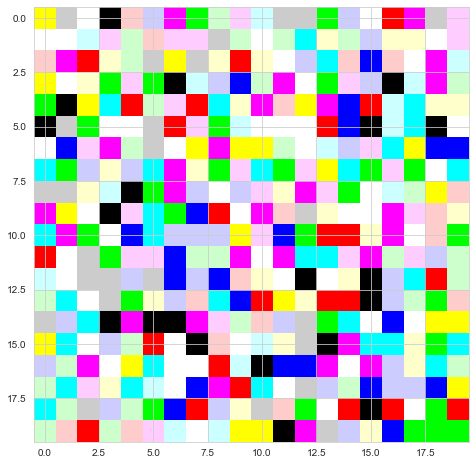

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd


def plot_model(model, ax):
    grid = np.zeros((model.height, model.width, 4))

    for (cell, i, j) in model.grid.coord_iter():
        value = [0,0,0,0] #in case not every cell is filled, the default colour is white
        if cell is not None:
            value = traits_to_color(cell)
        grid[i,j] = value          
    plt.imshow(grid)
    
fig, ax = plt.subplots()
plot_model(model, ax)

plt.show()

<AxesSubplot:>

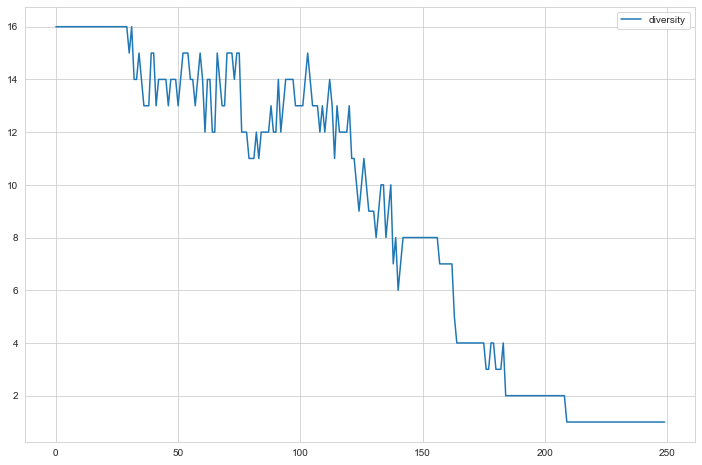

In [22]:
for _ in range(250):
    model.step()
model.datacollector.get_model_vars_dataframe().plot()